# Extract a region of the total Himawari-8 dataset

 To put onto cloudstor

In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask_jobqueue import SLURMCluster


In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(16)
client


Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Client Scheduler: tcp://146.118.38.114:40714 Dashboard: http://146.118.38.114:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import pandas as pd
from matplotlib import animation
import glob
import cmocean
import cartopy
import zarr

from matplotlib.colors import LightSource
from scipy import ndimage
# import geoviews as gv
# import geoviews.feature as gf

In [4]:
# Open the object as a zarr file
outpath = '/home/mrayson/scratch/HIMAWARI/raw_zarr'
ds = xr.open_zarr(outpath)
ds.time.values[0],ds.time.values[-1],ds

(numpy.datetime64('2016-01-01T00:00:17.000000000'),
 numpy.datetime64('2019-12-31T23:00:17.000000000'),
 <xarray.Dataset>
 Dimensions:                  (lat: 6001, lon: 6001, time: 34688)
 Coordinates:
   * lat                      (lat) float32 60.0 59.98 59.96 ... -59.979996 -60.0
   * lon                      (lon) float32 80.0 80.02 80.04 ... 199.98 200.0
   * time                     (time) datetime64[ns] 2016-01-01T00:00:17 ... 20...
 Data variables:
     sea_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(1, 6001, 6001), meta=np.ndarray>
 Attributes:
     Conventions:                CF-1.4,Unidata Observation Dataset v1.0
     Metadata_Conventions:       Unidata Observation Dataset v1.0
     acknowledgment:             Please acknowledge the use of these data with...
     algorithm_version:          1.02
     cdm_data_type:              grid
     comment:                    SST from AHI
     contact:                    ghrsst@eorc.jaxa.jp
     creator_email: 

In [5]:
# Subset the total data set
extents = [104,140,-26,-4]
textents = ['2017-02-01','2017-06-01']
chunks=None
# outpath = '/home/mrayson/scratch/HIMAWARI/NWS_SST_nighttime_FebJun2017.nc'
outpath = '../DATA/NWS_SST_nighttime_FebJun2017.nc'


sst = ds['sea_surface_temperature'].sel(lon=slice(extents[0], extents[1]), lat=slice(extents[3], extents[2]),
              time=slice(textents[0],textents[1]))
sst


,Array,Chunk
Bytes,23.02 GB,7.93 MB
Shape,"(2902, 1101, 1801)","(1, 1101, 1801)"
Count,37591 Tasks,2902 Chunks
Type,float32,numpy.ndarray


In [6]:
basetime = '2017-01-01'
hournight = 16

In [126]:
#sst = ds['sea_surface_temperature'].sel(lon=slice(120,120.02),lat=slice(-13,-13.01),\
#                            time=slice('2017-02-01','2017-06-01')).persist()
# print(sst.mean())

In [7]:
#yearday = np.array( [pd.to_datetime(tt).day for tt in sst.time.values] )
yearday = np.array([np.floor((tt - np.datetime64(basetime)).astype(np.float64)*1e-9/86400)\
           for tt in sst.time.values])
hourofday = np.array( [pd.to_datetime(tt).hour for tt in sst.time.values] )

# get the year day for night time hours only
nightday = yearday*1
idx = (hourofday<12) | (hourofday>20)
nightday[idx] = 0

In [8]:
# Add the nightday variable to the data set
sst['nightday'] = (['time'], nightday)

In [9]:
sst_night_mu = sst.groupby('nightday').mean()
sst_night_var = sst.groupby('nightday').var()

sst_night_mu

,Array,Chunk
Bytes,967.66 MB,7.93 MB
Shape,"(122, 1101, 1801)","(1, 1101, 1801)"
Count,44607 Tasks,122 Chunks
Type,float32,numpy.ndarray


In [10]:
# Create a new time variable for the output data set
timenight = (np.datetime64(basetime) + \
             (sst_night_mu['nightday'].values*24).astype('timedelta64[h]')+\
             hournight ).astype('<M8[ns]')
timenight[0:10]

array(['2017-01-01T16:00:00.000000000', '2017-02-01T16:00:00.000000000',
       '2017-02-02T16:00:00.000000000', '2017-02-03T16:00:00.000000000',
       '2017-02-04T16:00:00.000000000', '2017-02-05T16:00:00.000000000',
       '2017-02-06T16:00:00.000000000', '2017-02-07T16:00:00.000000000',
       '2017-02-08T16:00:00.000000000', '2017-02-09T16:00:00.000000000'],
      dtype='datetime64[ns]')

In [11]:
dsout = xr.Dataset({'sst_night_mu':sst_night_mu.rename('sst_night_mu').assign_coords({'nightday':timenight}),
                     'sst_night_var':sst_night_var.rename('sst_night_var').assign_coords({'nightday':timenight})
                   }).rename_dims({'nightday':'time'}).rename({'nightday':'time'})

#dsout=dsout.assign_coords({'time':timenight})

dsout

,Array,Chunk
Bytes,967.66 MB,7.93 MB
Shape,"(122, 1101, 1801)","(1, 1101, 1801)"
Count,44607 Tasks,122 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,967.66 MB,7.93 MB
Shape,"(122, 1101, 1801)","(1, 1101, 1801)"
Count,44607 Tasks,122 Chunks
Type,float32,numpy.ndarray


In [12]:
%%time
compressor = {'zlib':1}

encoding = {}
for vv in ['sst_night_mu', 'sst_night_var']:
    encoding.update({vv:compressor})
    
dsout.to_netcdf(outpath, encoding=encoding)

CPU times: user 1min 48s, sys: 6.86 s, total: 1min 55s
Wall time: 13min 21s


In [14]:
dsout

,Array,Chunk
Bytes,967.66 MB,7.93 MB
Shape,"(122, 1101, 1801)","(1, 1101, 1801)"
Count,44607 Tasks,122 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,967.66 MB,7.93 MB
Shape,"(122, 1101, 1801)","(1, 1101, 1801)"
Count,44607 Tasks,122 Chunks
Type,float32,numpy.ndarray


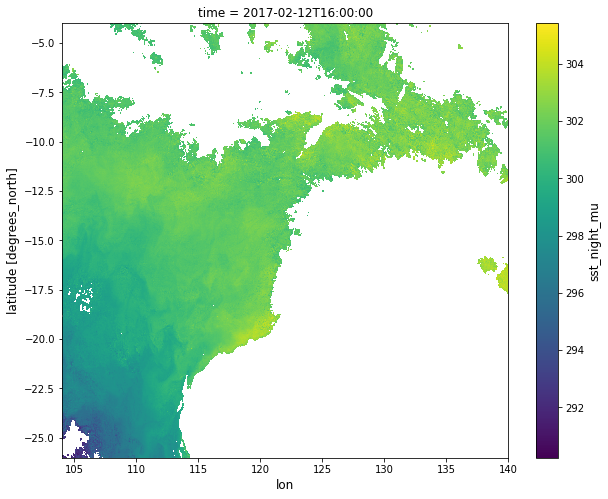

In [17]:
plt.figure(figsize=(10,8))
#dsout['sst_night_mu'].sel(time='2017-04-01',method='nearest').plot()
dsout['sst_night_mu'][12,...].plot()


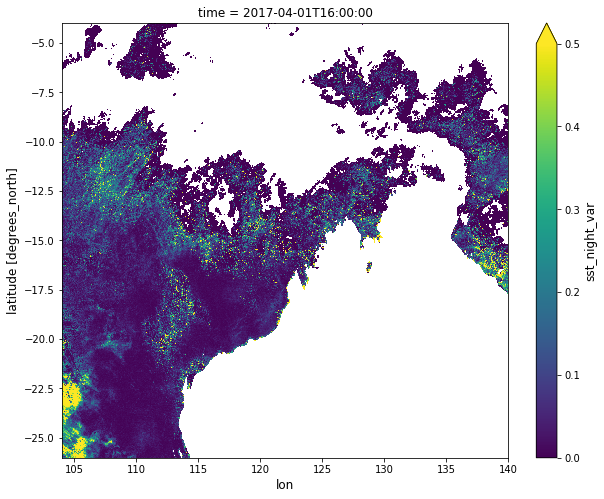

In [19]:
plt.figure(figsize=(10,8))
#dsout['sst_night_var'].sel(time='2017-04-01',method='nearest').plot(vmax=0.5)
dsout['sst_night_var'][60,...].plot(vmax=0.5)